<a href="https://colab.research.google.com/github/Vicente836/Practica-Ihealth/blob/S3/Segmentation_to_mesh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get install -qq xvfb libgl1-mesa-glx
!pip install pyvista -qq
import pyvista
pyvista.set_jupyter_backend('static')
pyvista.global_theme.notebook = True
pyvista.start_xvfb()

Selecting previously unselected package libfontenc1:amd64.
(Reading database ... 123635 files and directories currently installed.)
Preparing to unpack .../0-libfontenc1_1%3a1.1.4-1build3_amd64.deb ...
Unpacking libfontenc1:amd64 (1:1.1.4-1build3) ...
Selecting previously unselected package libgl1-mesa-glx:amd64.
Preparing to unpack .../1-libgl1-mesa-glx_23.0.4-0ubuntu1~22.04.1_amd64.deb ...
Unpacking libgl1-mesa-glx:amd64 (23.0.4-0ubuntu1~22.04.1) ...
Selecting previously unselected package libxfont2:amd64.
Preparing to unpack .../2-libxfont2_1%3a2.0.5-1build1_amd64.deb ...
Unpacking libxfont2:amd64 (1:2.0.5-1build1) ...
Selecting previously unselected package libxkbfile1:amd64.
Preparing to unpack .../3-libxkbfile1_1%3a1.1.0-1build3_amd64.deb ...
Unpacking libxkbfile1:amd64 (1:1.1.0-1build3) ...
Selecting previously unselected package x11-xkb-utils.
Preparing to unpack .../4-x11-xkb-utils_7.7+5build4_amd64.deb ...
Unpacking x11-xkb-utils (7.7+5build4) ...
Selecting previously unselec

In [ ]:
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt
import nibabel as nib

In [ ]:
# Load the NIfTI file
nifti_file = "time_01.nii"  # Replace with your file path
nifti_data = nib.load(nifti_file)
# Extract the image data as a NumPy array
image_data = nifti_data.get_fdata()
# Check the shape of the image
print(f"Image shape: {image_data.shape}")

Image shape: (384, 384, 14)


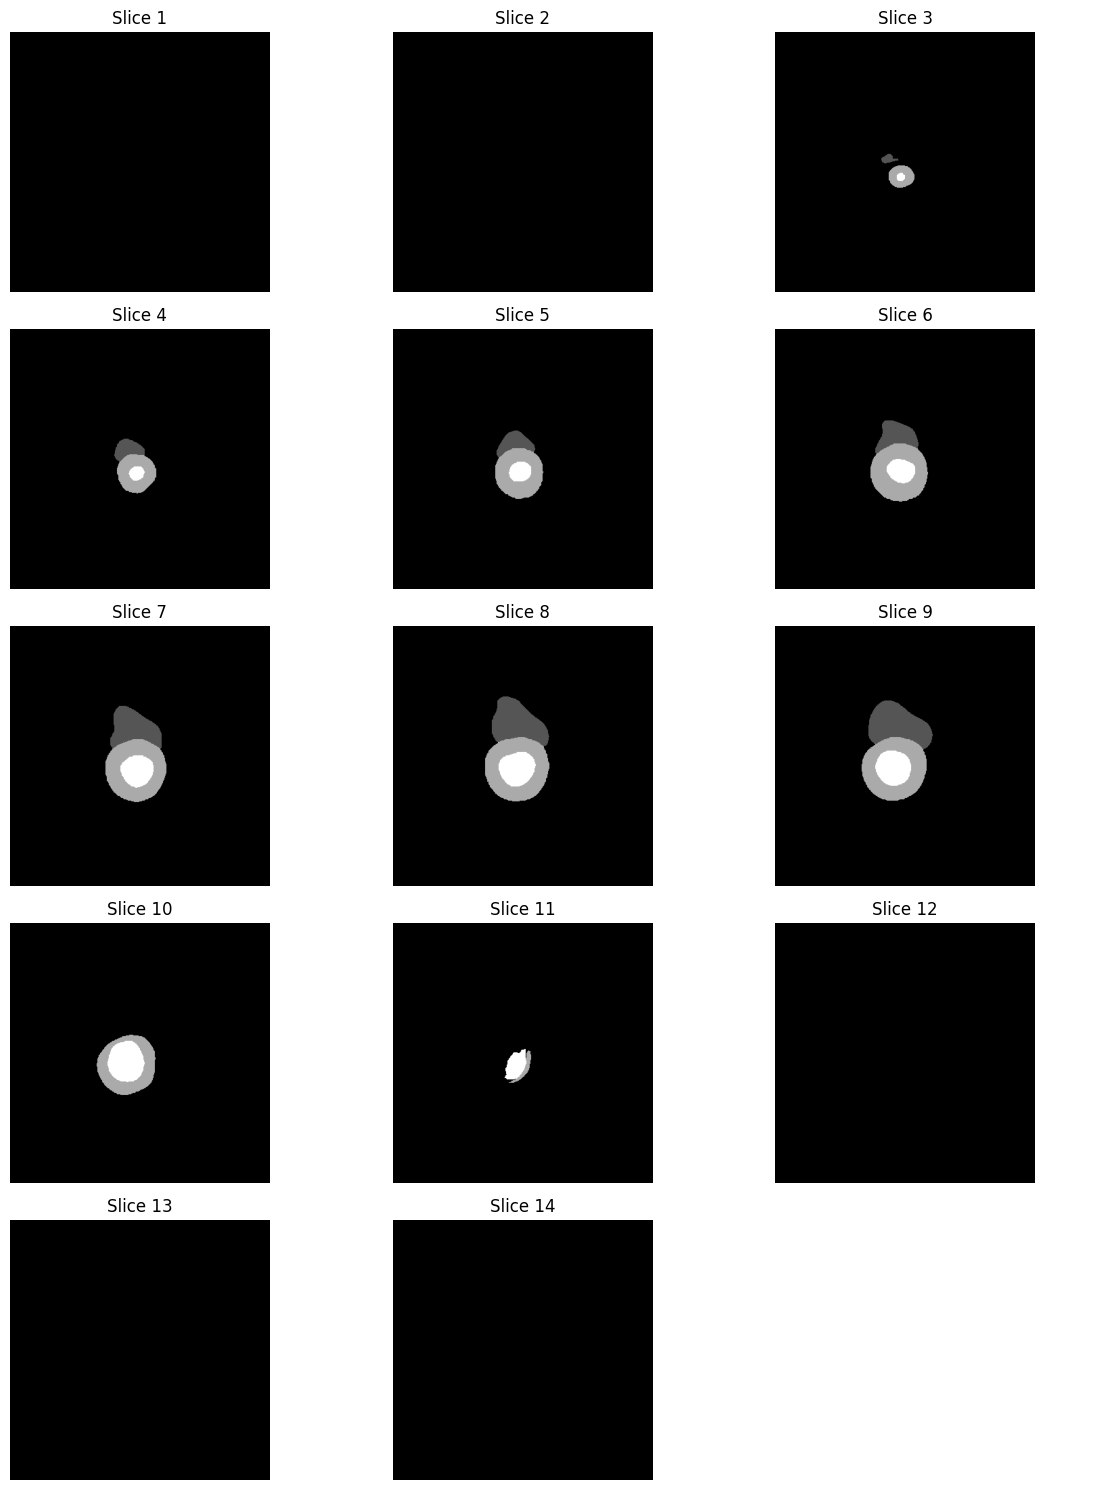

In [ ]:
num_slices = image_data.shape[2]
slice_indices = range(num_slices)
# Create a subplot (5 rows x 3 columns)
fig, axes = plt.subplots(5, 3, figsize=(12, 15))
# Loop through each subplot and plot the corresponding slice
for i, ax in enumerate(axes.flat):
    if i < len(slice_indices):
        slice_idx = slice_indices[i]
        ax.imshow(image_data[:, :, slice_idx], cmap="gray")
        ax.set_title(f"Slice {slice_idx+1}")
        ax.axis("off")
    else:
        ax.axis("off")  # Turn off empty subplots

plt.tight_layout()
plt.show()

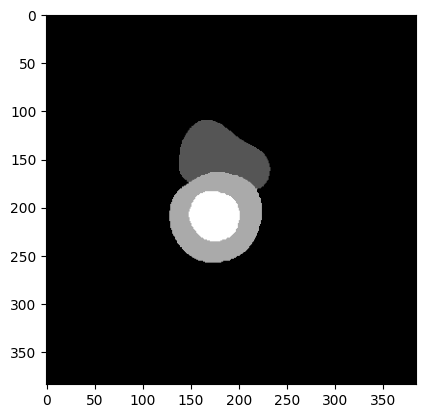

In [ ]:
N = image_data.shape[0]
slice8 = image_data[:, :, 8]
plt.imshow(slice8, cmap="gray")
spacing = nifti_data.header.get_zooms()


In [ ]:
spacing

(0.6451613, 0.6451613, 10.0)

In [ ]:
spacing[0]

0.6451613

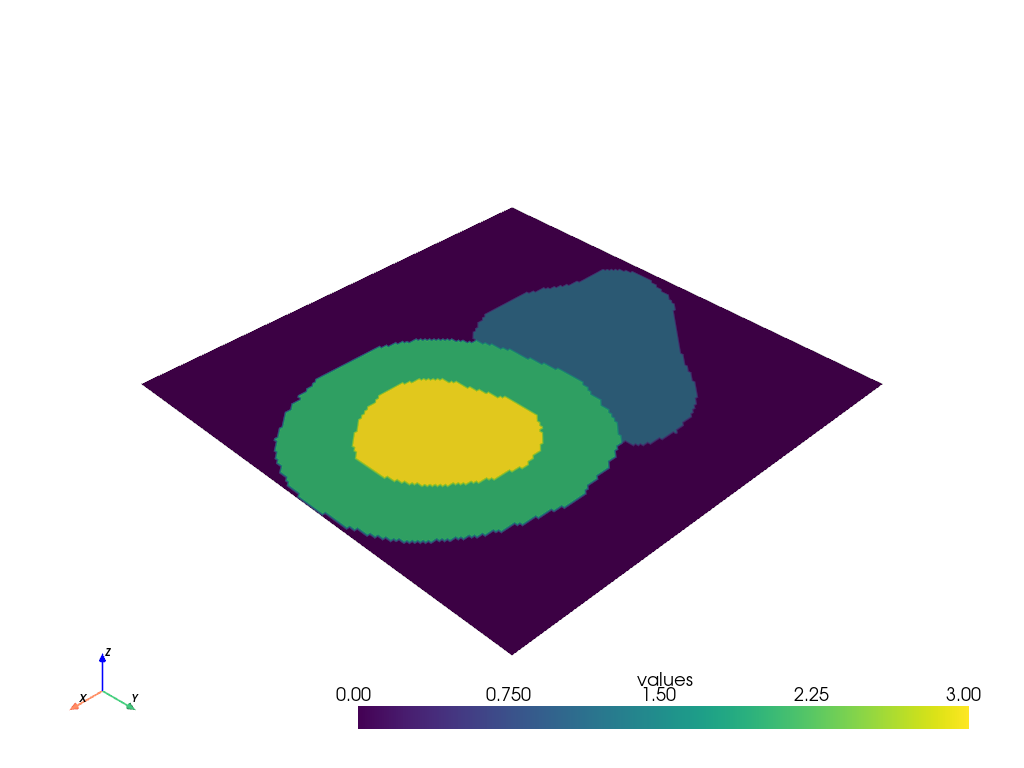

In [ ]:
N = image_data.shape[0]
# Se crea mallado base donde interpolar

x = np.linspace(0, 80, 160)  # 100 points along x-axis
y = np.linspace(0, 80, 160)  # 100 points along y-axis
# Create a grid of points
x, y = np.meshgrid(x, y)
z = np.ones_like(x)*63.6035
surface = pv.StructuredGrid(x, y, z)
surface["values"] = slice8.flatten()
surface.plot()

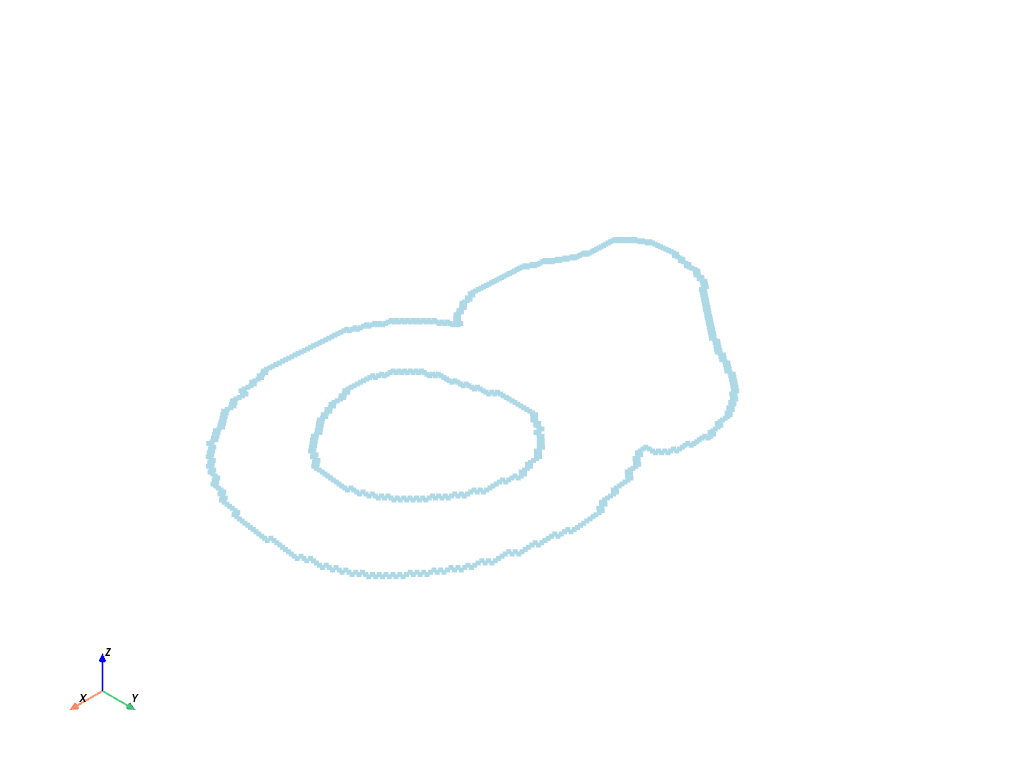

In [ ]:
surface_th = surface.threshold((1,2)).extract_feature_edges()
points = pv.PolyData(surface_th.points)
points.plot()


In [ ]:
# create point cloud from multiple slices
def point_cloud(slices):
  point_cloud = []
  for sl in slices:
    points = sl.points
    point_cloud.extend(points)
  return pv.PolyData(point_cloud)

def nifti_to_mesh(nifti_file):
  nifti_data = nib.load(nifti_file)
  # Extract the image data as a NumPy array
  image_data = nifti_data.get_fdata()
  spacing = nifti_data.header.get_zooms()
  voxel = spacing[0]
  dh =  spacing[2]
  N = image_data.shape[0]
  rng = N*voxel
  num_slices = image_data.shape[2]
  edges_s  = []
  for i in range(num_slices):
    slice_ = image_data[:, :, i]
    # Se crea mallado base
    x = np.linspace(-rng, rng, N)  # 100 points along x-axis
    y = np.linspace(-rng, rng, N)  # 100 points along y-axis
    # Create a grid of points
    x, y = np.meshgrid(x, y)
    h = dh*i #altura de la imagen
    z = np.ones_like(x)*h
    surface = pv.StructuredGrid(x, y, z)
    surface["values"] = slice_.flatten()
    edges = surface.threshold((1,2)).extract_feature_edges()
    if len(edges.points) > 0:
      edges_s.append(edges)

  return point_cloud(edges_s)

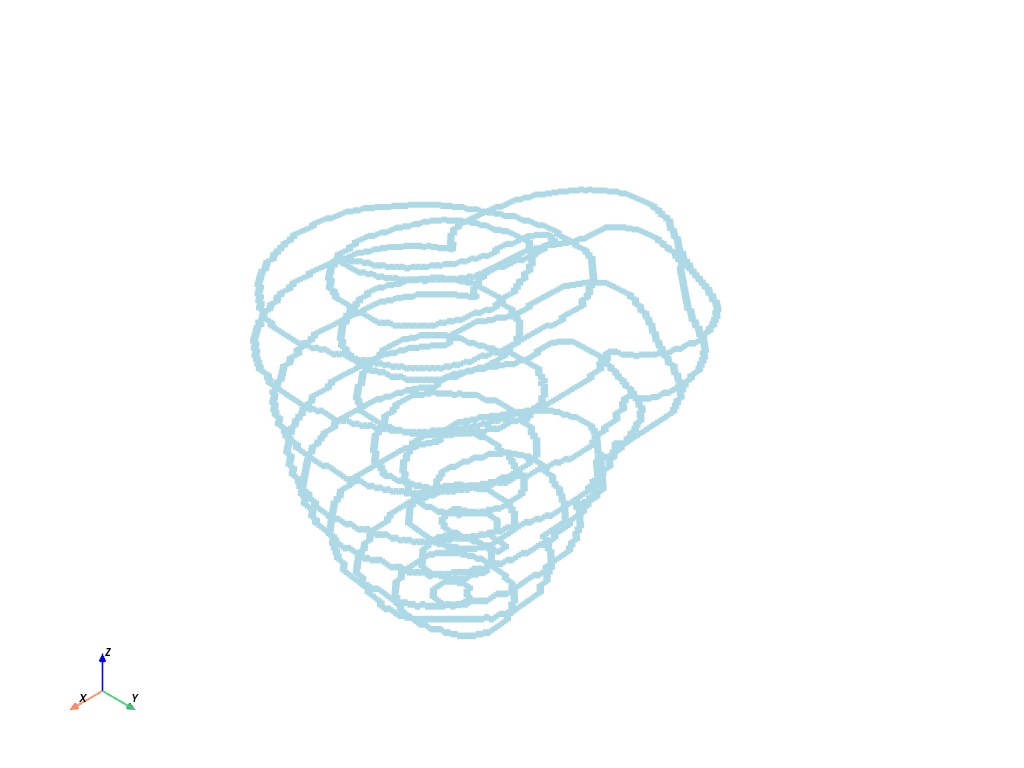

In [ ]:
mesh = nifti_to_mesh("time_01.nii")
mesh.plot()

In [ ]:
xrng = np.arange(-10, 10, 2, dtype=np.float32)
yrng = np.arange(-10, 10, 5, dtype=np.float32)
zrng = np.arange(-10, 10, 1, dtype=np.float32)
x, y, z = np.meshgrid(xrng, yrng, zrng, indexing='ij')
grid = pv.StructuredGrid(x, y, z)
grid

StructuredGrid,Information
N Cells,513
N Points,800
X Bounds,"-1.000e+01, 8.000e+00"
Y Bounds,"-1.000e+01, 5.000e+00"
Z Bounds,"-1.000e+01, 9.000e+00"
Dimensions,"10, 4, 20"
N Arrays,0


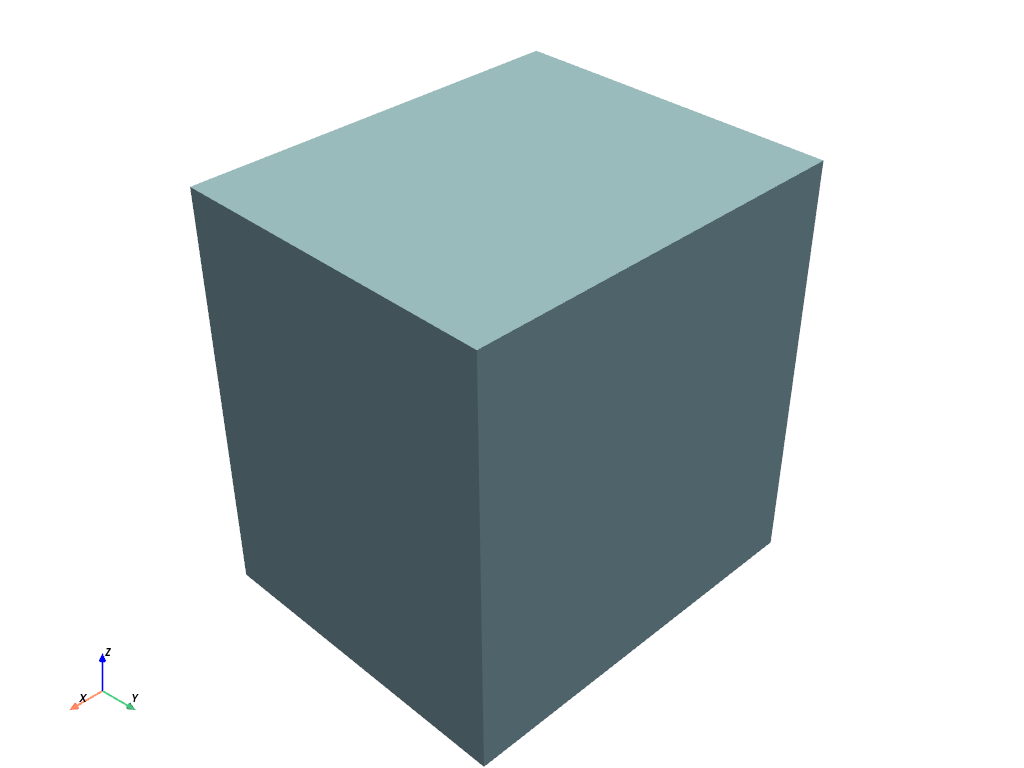

In [ ]:
grid.plot()

In [ ]:
image_data.flatten(order="F")

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [ ]:
nifti_data.header.get_zooms()

(0.6451613, 0.6451613, 10.0)

In [ ]:
# Convert the image data to a PyVista UniformGrid
dims = image_data.shape
grid = pv.UniformGrid(dims)

# Define the grid origin and spacing
grid.origin = (0, 0, 0)  # Typically (0, 0, 0) but can be set based on affine
grid.spacing = nifti_data.header.get_zooms()  # Voxel spacing from NIfTI header

# Add the image data to the grid
grid.point_data["values"] = image_data.flatten(order="F")

# Visualize the volume
grid.plot(volume=True, cmap="gray", opacity="sigmoid")


AttributeError: module 'pyvista' has no attribute 'UniformGrid'